# MLflow Experiment Tracking 
MLflow tracking is a powerful tool for logging and organizing machine learning experiments. It provides a centralized repository to log parameters, metrics, artifacts, and code versions. Here are some key concepts:

- **Experiment**: A named process, typically representing a machine learning workflow, that can contain multiple runs.
- **Run**: A single execution of a script or piece of code within an experiment.
- **Parameters**: Input values to a run, such as hyperparameters.
- **Metrics**: Output values or performance indicators logged during a run.
- **Artifacts**: Output files, such as models or plots, logged during a run.

By using MLflow, teams can effectively track and reproduce experiments, facilitating collaboration and model reproducibility.

## Exercise Overview
In this exercise, we'll explore how to leverage MLflow to log and organize metrics, parameters, and artifacts in the context of machine learning workflows.

## 1) - Logging Metrics and Parameters with MLflow
> *Note:* The tracking server can be reached via the URL `http://localhost:5001`.

In this exercise, we will practice using MLflow to log metrics and parameters in a machine learning workflow.
We will use the same functions as we used in the dagster ops job exercise.


### Part 1: Create an experiment and start a run

In [57]:
import time
from typing import Tuple

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    precision_score,
)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost.callback import TrainingCallback

In [2]:
mlflow_tracking_uri = "http://mlflow:5001"
mlflow.set_tracking_uri(mlflow_tracking_uri)

In [3]:
try:
    exp_id = mlflow.create_experiment(
        name="Spotify genre classification", tags={"workshop": "M3 April 2024"}
    )
except mlflow.exceptions.RestException:
    exp_id = mlflow.get_experiment_by_name(
        name="Spotify genre classification"
    ).experiment_id

In [4]:
_ = mlflow.start_run(experiment_id=exp_id)

<ActiveRun: >

In [5]:
mlflow.end_run()

In [6]:
with mlflow.start_run(experiment_id=exp_id):
    time.sleep(2)

### Part 2: Log parameters and metrics

In [26]:
_ = mlflow.start_run(experiment_id=exp_id)

In [27]:
def split_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    data = pd.read_csv("./data/genres_standardized.csv", sep=";")
    columns = list(data.columns)
    columns.remove("genre")
    data["genre"] = data["genre"].astype("category")
    data["target"] = data["genre"].cat.codes
    test_size = 0.2
    mlflow.log_param(key="test_size", value=test_size)
    X_train, X_test, y_train, y_test = train_test_split(
        data[columns], data["target"], test_size=test_size
    )
    return X_train, X_test, y_train, y_test, data["genre"]

In [52]:
input_train, input_test, target_train, target_test, target_names = split_data()

In [29]:
class MlflowCallback(TrainingCallback):
    def after_iteration(self, model, epoch, evals_log) -> bool:
        for data, metric in evals_log.items():
            for metric_name, log in metric.items():
                mlflow.log_metric(
                    key=metric_name, value=sum(log) / len(log), step=epoch
                )
        return False

In [30]:
def train_classifier(
    input_train: pd.DataFrame, target_train: pd.Series
) -> XGBClassifier:
    number_of_estimators: int = 100
    learning_rate: float = 0.1
    max_depth: int = 8
    min_child_weight: float = 1.0
    gamma: float = 0
    number_of_jobs: int = 4

    model = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=number_of_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        n_jobs=number_of_jobs,
        callbacks=[MlflowCallback()],
    )
    model.fit(
        input_train, target_train, eval_set=[(input_train, target_train)], verbose=False
    )

    return model

In [31]:
classifier = train_classifier(input_train, target_train)
mlflow.end_run()

In [69]:
mlflow.end_run()

## 2) Log models, artifacts and datasets

In [43]:
_ = mlflow.start_run(experiment_id=exp_id)

In [44]:
classifier = train_classifier(input_train, target_train)
mlflow.xgboost.log_model(classifier, "spotify_genre_classifier")

/opt/pysetup/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/pysetup/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [45]:
def predict(classifier: XGBClassifier, input_test: pd.DataFrame) -> np.ndarray:
    predictions = classifier.predict(input_test)
    return predictions

In [48]:
predictions = predict(classifier=classifier, input_test=input_test)

In [59]:
def analyze(
    target_test: pd.Series,
    predictions: np.ndarray,
    target_names: pd.Series,
):
    category_labels = target_names.cat.categories
    fig, ax = plt.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay.from_predictions(
        target_test, predictions, ax=ax, display_labels=category_labels
    )
    ax.tick_params(axis="x", labelrotation=70, labelbottom=True)
    fig.savefig("./data/confusion_materix.png", pad_inches=20)
    report = classification_report(target_test, predictions, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report.to_csv("./data/classification_report.csv")
    mlflow.log_artifact("./data/classification_report.csv")
    mlflow.log_artifact("./data/confusion_materix.png")

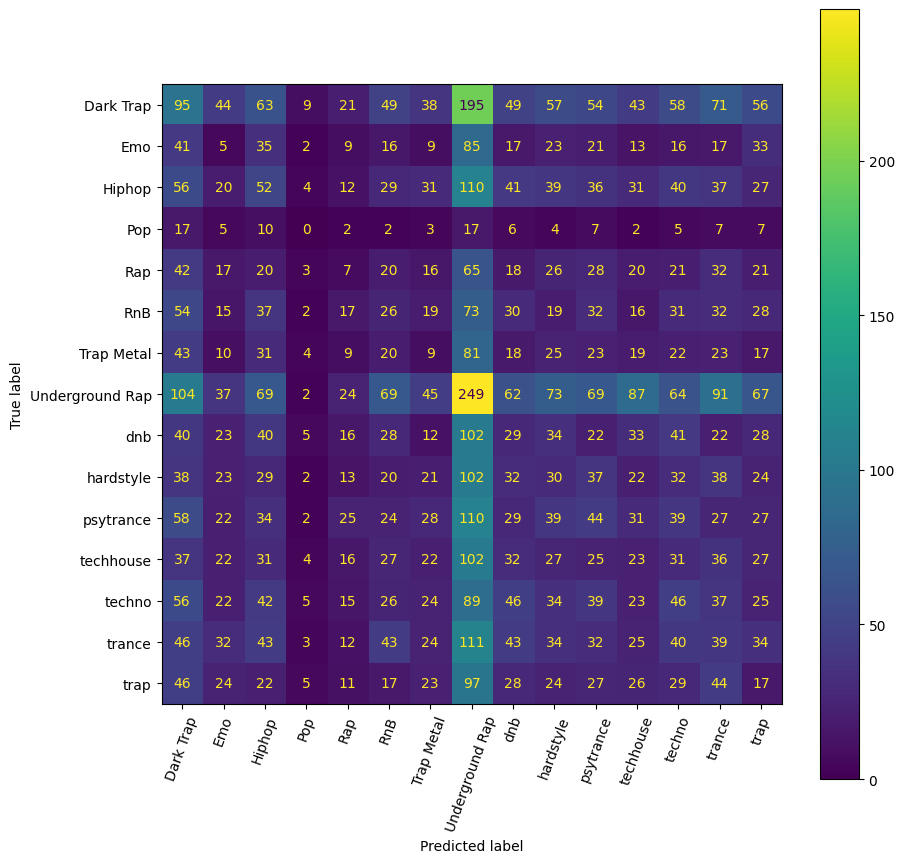

In [60]:
analyze(target_test=target_test, predictions=predictions, target_names=target_names)
mlflow.end_run()

In [68]:
_ = mlflow.start_run(experiment_id=exp_id)
data = pd.read_csv("./data/genres_standardized.csv", sep=";")
dataset = mlflow.data.from_pandas(data, targets="genre")
mlflow.log_input(dataset)
mlflow.end_run()

/opt/pysetup/.venv/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/opt/pysetup/.venv/lib/python3.11/site-packages/mlflow/data/pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  return _infe

/opt/pysetup/.venv/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/opt/pysetup/.venv/lib/python3.11/site-packages/mlflow/data/pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  return _infe

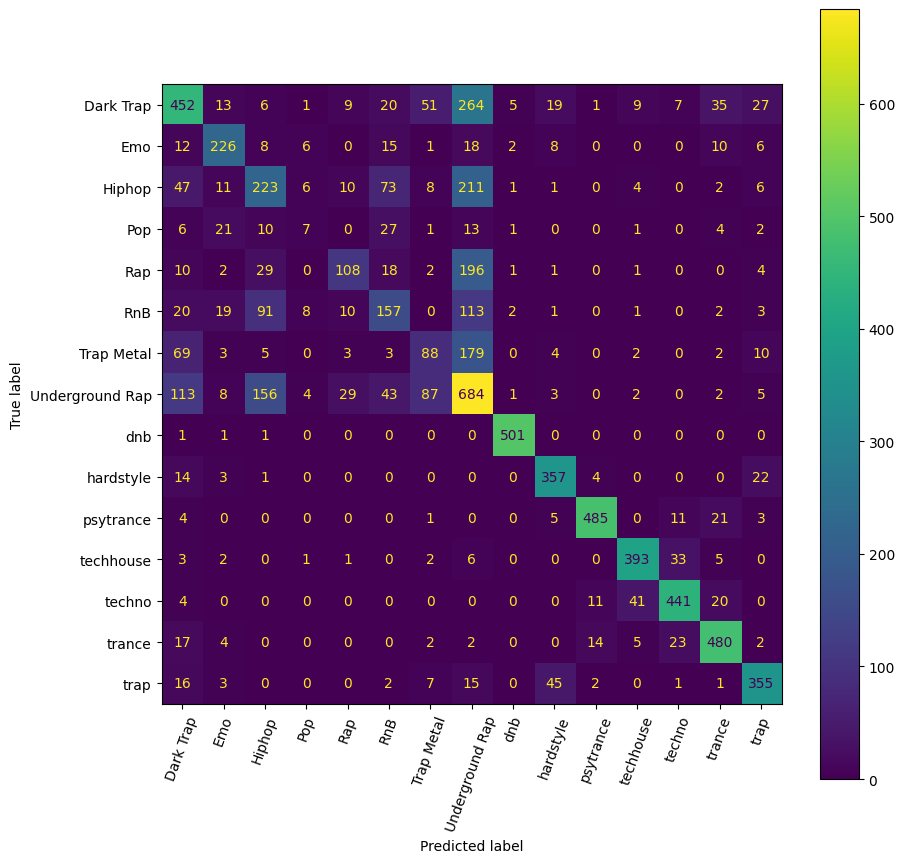

In [72]:
with mlflow.start_run(experiment_id=exp_id):
    data = pd.read_csv("./data/genres_standardized.csv", sep=";")
    dataset = mlflow.data.from_pandas(data, targets="genre")
    mlflow.log_input(dataset)
    input_train, input_test, target_train, target_test, target_names = split_data()
    classifier = train_classifier(input_train, target_train)
    mlflow.xgboost.log_model(classifier, "spotify_genre_classifier")
    predictions = predict(classifier=classifier, input_test=input_test)
    analyze(target_test=target_test, predictions=predictions, target_names=target_names)


## Exercise 2 - PyTorch Image Classifier with MLflow
> **Objective**: In this exercise, we'll create an image classifier with PyTorch and use MLflow to monitor the trained model.

### Part 1: Setting Up
The second exercise involves creating a PyTorch-based image classifier using Fashion MNIST. We define a simple Convolutional Neural Network (CNN) architecture.

In [ ]:
import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from torchvision.datasets import CIFAR10
from tqdm import tqdm

In [ ]:
# Load the Fashion MNIST Dataset and Apply Necessary Transformations
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 4, data_path: str = "./data/FASHIONMNIST"):
        super().__init__()
        self.data_path = data_path
        self.batch_size = batch_size

    def prepare_data(self):
        datasets.FashionMNIST(self.data_path, download=True)

    def setup(self, stage=None):
        transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )

        if stage == "fit" or stage is None:
            self.train_dataset = datasets.FashionMNIST(
                "./data/FASHIONMNIST", train=True, transform=transform
            )

        if stage == "test" or stage is None:
            self.test_dataset = datasets.FashionMNIST(
                "./data/FASHIONMNIST", train=False, transform=transform
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2
        )

In [ ]:
batch_size = 64
learning_rate = 0.001
epochs = 2


data_module = FashionMNISTDataModule(batch_size=batch_size)
data_module.prepare_data()
data_module.setup()

### Part 2: Training the Model
You will log parameters (e.g., learning rate, batch size, epochs) and the loss per epoch during the training process. Additionally, you'll log the trained model as an artifact.

In [ ]:
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F


class FashionMNISTModel(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super(FashionMNISTModel, self).__init__()
        self.learning_rate = learning_rate
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        #! Log the loss per epoch

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer


model = FashionMNISTModel(learning_rate=learning_rate)

model.prepare_data = data_module.prepare_data
model.setup = data_module.setup

In [ ]:
try:
    mlflow.set_tracking_uri("http://mlflow:5001")
    #! Create an experiment with the name `MLflow Image Classifier Demo`. Save the experiment_id in the variable `exp_id`.
except mlflow.exceptions.RestException:
    exp_id = mlflow.get_experiment_by_name(
        name="MLflow Image Classifier Demo"
    ).experiment_id

In [ ]:
# Train the Model
with mlflow.start_run(experiment_id=exp_id):
    #! Log the variables `batch_size`, `learning_rate`, and `epochs` as parameters

    trainer = pl.Trainer(max_epochs=epochs)
    trainer.fit(model, data_module)

    model_path = "model.pth"
    torch.save(model.state_dict(), model_path)

    #! Log the saved model as an artifact

### Part 3: Additional Tasks
These tasks extend the exercise by logging the trained model using mlflow.pytorch.log_model and incorporating a function to create and log a confusion matrix.
1. Log the trained model using `mlflow.pytorch.log_model`.
2. Insert the call to the following function `create_confusion_matrix` in the above code block. First, execute the cell with the function. The saved confusion matrix should be logged as an artifact.
3. Copy the cell above. Delete all mlflow logging functions and add `mlflow.pytorch.autolog` before you start a mlflow run. Look at the results at the Mlflow Tracking Server

In [ ]:
def create_confusion_matrix(filename, model, testloader):
    y_pred = []
    y_true = []

    for inputs, labels in testloader:
        output = model(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

    classes = (
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle Boot",
    )

    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(
        cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
        index=[i for i in classes],
        columns=[i for i in classes],
    )
    plt.figure(figsize=(12, 7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig(filename)